In [55]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [56]:
def diff_data(path):
  data = pd.read_csv(path);
  # Apply logarithmic transformation
  data['log_close'] = np.log(data['Close'])
  # Calculate the first-order difference (residual) of the 'Close' prices
  data['log_close_diff'] = data['log_close'].diff()
  data = data.dropna()
  return data

In [57]:
# loading dataset
data = diff_data('./IBM.csv')

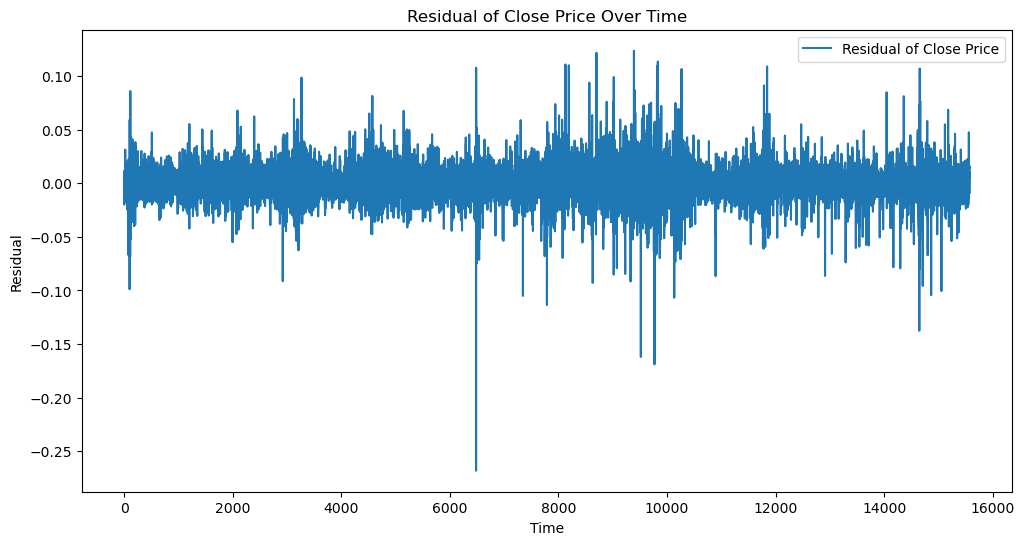

In [58]:
# plot diff
plt.figure(figsize=(12, 6))
plt.plot(data['log_close_diff'], label='Residual of Close Price')
plt.title('Residual of Close Price Over Time')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

In [59]:
def prepare_and_build_rnn_model(data, look_back=25):
    # Standardize the residuals
    scaler = StandardScaler()
    scaled_residual = scaler.fit_transform(data['log_close_diff'].values.reshape(-1, 1))

    # Function to create dataset
    def create_dataset(dataset, look_back):
        X, Y = [], []
        for i in range(len(dataset) - look_back - 1):
            a = dataset[i:(i + look_back), 0]
            X.append(a)
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

    # Split into training and testing sets
    train_size = int(len(scaled_residual) * 0.8)
    test_size = len(scaled_residual) - train_size
    train, test = scaled_residual[0:train_size,:], scaled_residual[train_size:len(scaled_residual),:]

    # Create training and testing data
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))

    # Build the RNN model with Dropout layers
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(look_back, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model, X_train, Y_train, X_test, Y_test, scaler


In [60]:
def train_and_plot_loss(model, X_train, Y_train, epochs=100, batch_size=128):
    # Train the model and record the history
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=2)

    # Plotting the training loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

Epoch 1/300
98/98 - 2s - loss: 1.2007 - 2s/epoch - 24ms/step
Epoch 2/300
98/98 - 0s - loss: 1.1166 - 496ms/epoch - 5ms/step
Epoch 3/300
98/98 - 0s - loss: 1.0903 - 481ms/epoch - 5ms/step
Epoch 4/300
98/98 - 1s - loss: 1.0732 - 661ms/epoch - 7ms/step
Epoch 5/300
98/98 - 0s - loss: 1.0668 - 498ms/epoch - 5ms/step
Epoch 6/300
98/98 - 0s - loss: 1.0596 - 478ms/epoch - 5ms/step
Epoch 7/300
98/98 - 0s - loss: 1.0587 - 477ms/epoch - 5ms/step
Epoch 8/300
98/98 - 0s - loss: 1.0541 - 493ms/epoch - 5ms/step
Epoch 9/300
98/98 - 0s - loss: 1.0578 - 492ms/epoch - 5ms/step
Epoch 10/300
98/98 - 0s - loss: 1.0528 - 486ms/epoch - 5ms/step
Epoch 11/300
98/98 - 1s - loss: 1.0488 - 602ms/epoch - 6ms/step
Epoch 12/300
98/98 - 0s - loss: 1.0493 - 496ms/epoch - 5ms/step
Epoch 13/300
98/98 - 0s - loss: 1.0468 - 489ms/epoch - 5ms/step
Epoch 14/300
98/98 - 0s - loss: 1.0471 - 497ms/epoch - 5ms/step
Epoch 15/300
98/98 - 0s - loss: 1.0465 - 485ms/epoch - 5ms/step
Epoch 16/300
98/98 - 0s - loss: 1.0450 - 481ms/epoc

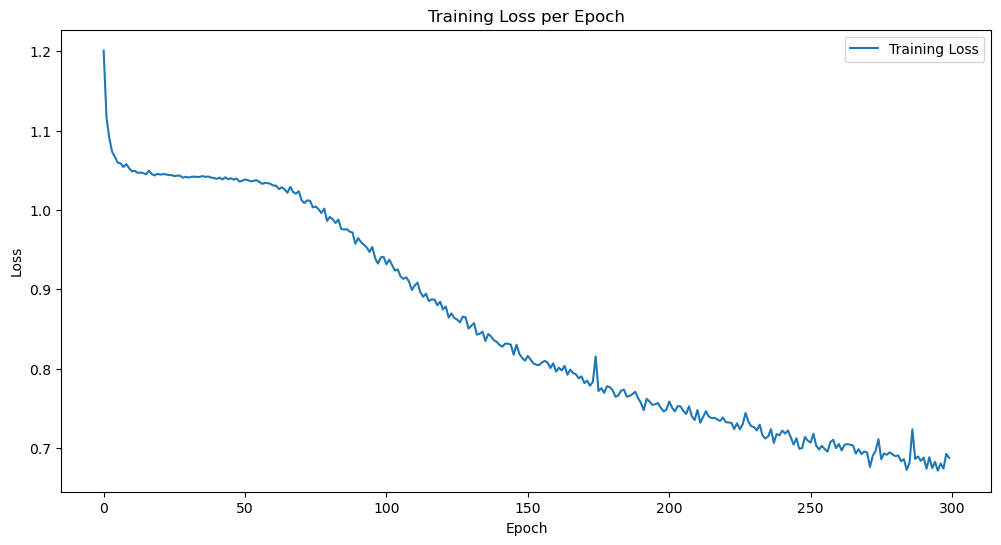

In [71]:
model, X_train, Y_train, X_test, Y_test, scaler = prepare_and_build_rnn_model(data, look_back=20)

trained_model = train_and_plot_loss(model, X_train, Y_train, epochs=300, batch_size=128)

In [69]:
def predict_and_plot(model, X_train, X_test, data, scaler):
    # Perform predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverse transform to original scale
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Apply inverse log differencing
    last_log_train_value = data['log_close'].values[len(train_predict) - 1]
    last_log_test_value = data['log_close'].values[-len(test_predict) - 1]
    train_predict = np.exp(last_log_train_value + train_predict[:,0])
    test_predict = np.exp(last_log_test_value + test_predict[:,0])

    # Calculate RMSE for test data
    test_rmse = sqrt(mean_squared_error(data['Close'].values[-len(test_predict):], test_predict))
    print('Test RMSE:', test_rmse)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'].values, label='Original Close Prices')
    plt.plot(np.arange(len(train_predict)), data['Close'].values[:len(train_predict)], label='Training Data')
    plt.plot(np.arange(len(train_predict), len(train_predict) + len(test_predict)), test_predict, label='Testing Predictions')
    plt.title('Stock Price Prediction using Log Differenced Residuals with RNN')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


97/97 [==============================] - 0s 1ms/step
Test RMSE: 33.88369187541113


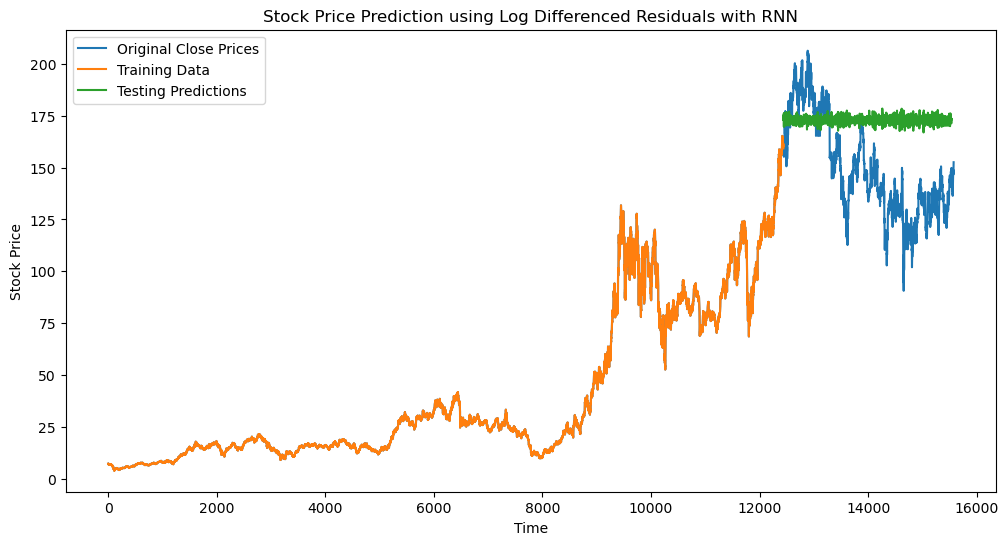

In [72]:
predict_and_plot(model, X_train, X_test, data, scaler)